# Linking IBES and CRSP Data
<p class="lead">IBES data with broker estimates of company earnings and CRSP data with the corresponding stock prices are often combined by linking common identifiers--particularly CUSIPS--in both datasets. This notebook explains a "Linking Table" approach for merging IBES and CRSP data.</p>

## Introduction
Combining broker estimates of company earnings and other financials in the IBES database with stock returns and other items in the CRSP Stock files requires knowledge of both data sets and how they use different company and security identification codes. Both databases use primary identifiers (IBES TICKER and CRSP PERMNO) that are unique in the sense that a single primary identifier is associated with each company or security. This uniqueness feature makes querying and organizing data from these sets straightforward (as opposed to using non-unique company names, exchange tickers or CUSIPs as identifiers). However, because these primary identifiers are specific to each database, merging or combining the IBES and CRSP sets can not be accomplished in a simple and direct manner.

In order to merge IBES data with CRSP data, the best approach is to use common secondary identifiers to construct a ‘linking table’ that makes a one-to-one correspondence between the two sets of primary identifiers. This notebook explains the ‘linking table’ approach, which can be applied to datasets other than IBES and CRSP.

## Identifier Files
Both the CRSP and IBES datasets have name or identifier files (ID for IBES Detail and IDSUM for IBES Summary data, and STOCKNAMES for CRSP Stock data) that contain all companies in each dataset and provide a map between their primary identifiers (e.g. IBES TICKER and CRSP PERMNO) and all other historical identifiers (e.g. CUSIP, Exchange Ticker). It is essential to use these name files in order to construct the link table.

### IBES IDs
The IBES identifier files track changes in historical company identifier information (including company name, official exchange ticker symbol, and CUSIP) for the entire IBES universe of firms. These identifier files are structured to show more than one exchange Ticker or CUSIP for a company (in the appropriate cases), which increases the likelihood of a correct link between the IBES and CRSP sets. The start date (SDATES) for each identifying record is also provided.

As of the IBES update in April 2006, the main identifier files in IBES are:

- Detail History name file: ID File: which contains 23,808 unique US and Canadian company IBES tickers
- Summary History name file: IDSUM File: which contains 15,576 unique US company IBES tickers

An important difference between ID and IDSUM is the coverage and identification of Canadian companies. While USFIRM dummy variable clearly designates US companies in IDSUM, the detail history ID file contains duplicate records for each Canadian company, with one record for USFIRM= 1 and another record for USFIRM= 0. This is due to IBES’ inclusion of the Canadian estimates in both the U.S. source file and the International source file. Therefore, it is easier to identify U.S. companies in the IDSUM set.

Since CRSP only tracks securities that are traded in major American exchanges, non-US companies should be eliminated from IBES sample before starting with the matching process. For this reason, it is more appropriate to use IDSUM in linking with CRSP. (For more information about IBES datasets, (See the IBES Manual, IBES Overview, and IBES dataset list on WRDS).

### CRSP IDs
CRSP STOCKNAMES file provides a map between CRSP permanent identifiers and all historical CUSIPs, Company Names, and Exchange Tickers, along with their effective date ranges. The following CRSP variables will be used in linking IBES with CRSP:

1. PERMNO is the unique identifier for CRSP securities. Similar to IBES TICKER, PERMNO does not change over time even if the company changes its name, CUSIP and exchange ticker.

2. TICKER is the exchange ticker in CRSP data, and it is analogous to OFTIC in IBES. However, TICKER may be a truncated version of the actual trading symbol when it has additional share class character(s) or more than 5 characters. (For more information on the CRSP exchange ticker, see the CRSP Manual page 104.)

3. COMNAM is the company name in CRSP at a specific point in time.

4. NCUSIP is the 8-digit historical CUSIP in CRSP data. NCUSIP is analogous to IBES’ CUSIP. CRSP also has another header variable named “CUSIP” which should not be used in linking with IBES, as “CUSIP” only reflects the most recent company CUSIP for the entire company time series.

5. NAMEDT and NAMEENDDT are the first and last effective dates of each set of name structure, which consists of CUSIP, Company Name, Exchange Code, Exchange Ticker, Share Class, and SIC Code. Each PERMNO has at least one name structure in STOCKNAMES file.

## Overview of Linking Logic
We conduct two layers of linking between IBES and CRSP database.

### CUSIP Link

CRSP NCUSIP and IBES CUSIP are both historical CUSIP for companies. We turn to entire 8-digit CUSIP as the initial mapping link. In order to enhance the linking accuracy, date ranges from both databases (NAMEDT and NAMEENDDT for CRSP, and SDATES for IBES) are also factored into the algorithm.

### GVKEY Link

Among the unmatched companies using CUSIP, a second layer of matching is conducted using Compustat.SECURITY table. This table contains the mapping information between Compustat's permanent identifiers (GVKEY, IID) and IBES Ticker (IBTIC). Utilizing the linkage here as well as the linking between GVKEY+IID and CRSP PERMNO through CCM's linking table, we can then link the IBES Ticker directly to CRSP Permno.

The summary flow is as the followings:

IBES Ticker <--(COMP.SECURITY) --> COMP GVKEY+IID 

<--(CRSP.CCMXPF_LINKTABLE) --> CRSP PERMNO

### Additional Control by Comparing Company Name String

On top of the linkage established using the two methods described above, an additional layer of quality check is imposed by comparing the string of company names from CRSP (COMNAM) and IBES (CNAME). While there are several string comparison packages available through Python, in this code we use FuzzyWuzzy for the purpose of company name matching. Users can easily swap this package with any other package of choice (e.g. jellyfish).

FuzzyWuzzy provides several methods for calculating the similarities between strings. We adopt the tokenized method of token_set_ratio in this code.

The output of the string comparison is a measure of similarity between the two input strings: 100 implies that the two company names are the same. Below are some examples of the string comparison between IBES' CNAME and CRSP's COMNAM variable.

In [ ]:
#!pip install fuzzywuzzy

from fuzzywuzzy import fuzz

In [5]:
fuzz.token_set_ratio('AMAZON.COM INC',  'AMAZON COM INC')

100

In [6]:
fuzz.token_set_ratio('1ST FED BCP DEL',  'FIRST FEDERAL BANCORP DE')

51

In [10]:
fuzz.token_set_ratio('INTERNATIONAL BUSINESS MACHS COR', 'INTL BUS MACH')

57

## ICLINK Python Code and Discussion

In [11]:
#####################################
# ICLINK: Link CRSP and IBES        #
# Sep 2019                          #
#####################################

# This program replicates the SAS macro ICLINK 
# to create a linking table between CRSP and IBES
# Output is a score reflecting the quality of the link
# Score = 0 (best link) to Score = 6 (worst link)
# 
# More explanation on score system:
# - 0: BEST match: using (cusip, cusip dates and company names)       
#          or (exchange ticker, company names and 6-digit cusip)     
# - 1: Cusips and cusip dates match but company names do not match    
# - 2: Cusips and company names match but cusip dates do not match    
# - 3: Cusips match but cusip dates and company names do not match    
# - 4: tickers and 6-digit cusips match but company names do not match   
# - 5: tickers and company names match but 6-digit cusips do not match        
# - 6: tickers match but company names and 6-digit cusips do not match        

import wrds
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Loading library list...
Done


### Step 1: Link by CUSIP

In [12]:
#########################
# Step 1: Link by CUSIP #
#########################

# 1.1 IBES: Get the list of IBES Tickers for US firms in IBES
_ibes1 = conn.raw_sql("""
                      select ticker, cusip, cname, sdates from ibes.id
                      where usfirm=1 and cusip != ''
                      """)

# Create first and last 'start dates' for a given cusip
# Use agg min and max to find the first and last date per group
# then rename to fdate and ldate respectively

_ibes1_date = _ibes1.groupby(['ticker','cusip']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

# merge fdate ldate back to _ibes1 data
_ibes2 = pd.merge(_ibes1, _ibes1_date,how='left', on =['ticker','cusip'])
_ibes2 = _ibes2.sort_values(by=['ticker','cusip','sdates'])

# keep only the most recent company name
# determined by having sdates = ldate
_ibes2 = _ibes2.loc[_ibes2.sdates == _ibes2.ldate].drop(['sdates'], axis=1)

# 1.2 CRSP: Get all permno-ncusip combinations
_crsp1 = conn.raw_sql("""
                      select permno, ncusip, comnam, namedt, nameenddt
                      from crsp.stocknames
                      where ncusip != ''
                      """)

# first namedt
_crsp1_fnamedt = _crsp1.groupby(['permno','ncusip']).namedt.min().reset_index()

# last nameenddt
_crsp1_lnameenddt = _crsp1.groupby(['permno','ncusip']).nameenddt.max().reset_index()

# merge both 
_crsp1_dtrange = pd.merge(_crsp1_fnamedt, _crsp1_lnameenddt, \
                          on = ['permno','ncusip'], how='inner')

# replace namedt and nameenddt with the version from the dtrange
_crsp1 = _crsp1.drop(['namedt'],axis=1).rename(columns={'nameenddt':'enddt'})
_crsp2 = pd.merge(_crsp1, _crsp1_dtrange, on =['permno','ncusip'], how='inner')

# keep only most recent company name
_crsp2 = _crsp2.loc[_crsp2.enddt ==_crsp2.nameenddt].drop(['enddt'], axis=1)

# 1.3 Create CUSIP Link Table

# Link by full cusip, company names and dates
_link1_1 = pd.merge(_ibes2, _crsp2, how='inner', left_on='cusip', right_on='ncusip')\
.sort_values(['ticker','permno','ldate'])

# Keep link with most recent company name
_link1_1_tmp = _link1_1.groupby(['ticker','permno']).ldate.max().reset_index()
_link1_2 = pd.merge(_link1_1, _link1_1_tmp, how='inner', on =['ticker', 'permno', 'ldate'])


# Calculate name matching ratio using FuzzyWuzzy

# Note: fuzz ratio = 100 -> match perfectly
#       fuzz ratio = 0   -> do not match at all

# Comment: token_set_ratio is more flexible in matching the strings:
# fuzz.token_set_ratio('AMAZON.COM INC',  'AMAZON COM INC')
# returns value of 100

# fuzz.ratio('AMAZON.COM INC',  'AMAZON COM INC')
# returns value of 93

_link1_2['name_ratio'] = _link1_2.apply(lambda x: fuzz.token_set_ratio(x.comnam, x.cname), axis=1)

# Note on parameters:
# The following parameters are chosen to mimic the SAS macro %iclink
# In %iclink, name_dist < 30 is assigned score = 0
# where name_dist=30 is roughly 90% percentile in total distribution
# and higher name_dist means more different names.
# In name_ratio, I mimic this by choosing 10% percentile as cutoff to assign
# score = 0

# 10% percentile of the company name distance
name_ratio_p10 = _link1_2.name_ratio.quantile(0.10)

# Function to assign score for companies matched by:
# full cusip and passing name_ratio
# or meeting date range requirement

def score1(row):
    if (row['fdate']<=row['nameenddt']) & (row['ldate']>=row['namedt']) & (row['name_ratio'] >= name_ratio_p10):
        score = 0
    elif (row['fdate']<=row['nameenddt']) & (row['ldate']>=row['namedt']):
        score = 1
    elif row['name_ratio'] >= name_ratio_p10:
        score = 2
    else:
        score = 3
    return score

# assign size portfolio
_link1_2['score']=_link1_2.apply(score1, axis=1)
_link1_2 = _link1_2[['ticker','permno','cname','comnam','name_ratio','score']]
_link1_2 = _link1_2.drop_duplicates()

### Step 2: Link by Ticker 

In [13]:
##########################
# Step 2: Link by TICKER #
##########################

# Find links for the remaining unmatched cases using Exchange Ticker 

# Identify remaining unmatched cases 
_nomatch1 = pd.merge(_ibes2[['ticker']], _link1_2[['permno','ticker']], on='ticker', how='left')
_nomatch1 = _nomatch1.loc[_nomatch1.permno.isnull()].drop(['permno'], axis=1).drop_duplicates()

# Add IBES identifying information

ibesid = conn.raw_sql(""" select ticker, cname, oftic, sdates, cusip from ibes.id """)
ibesid = ibesid.loc[ibesid.oftic.notna()]

_nomatch2 = pd.merge(_nomatch1, ibesid, how='inner', on=['ticker'])

# Create first and last 'start dates' for Exchange Tickers
# Label date range variables and keep only most recent company name

_nomatch3 = _nomatch2.groupby(['ticker', 'oftic']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

_nomatch3 = pd.merge(_nomatch2, _nomatch3, how='left', on=['ticker','oftic'])

_nomatch3 = _nomatch3.loc[_nomatch3.sdates == _nomatch3.ldate]

# Get entire list of CRSP stocks with Exchange Ticker information

_crsp_n1 = conn.raw_sql(""" select ticker, comnam, permno, ncusip, namedt, nameenddt
                            from crsp.stocknames """)

_crsp_n1 = _crsp_n1.loc[_crsp_n1.ticker.notna()].sort_values(by=['permno','ticker','namedt'])

# Arrange effective dates for link by Exchange Ticker

_crsp_n1_namedt = _crsp_n1.groupby(['permno','ticker']).namedt.min().reset_index().rename(columns={'min':'namedt'})
_crsp_n1_nameenddt = _crsp_n1.groupby(['permno','ticker']).nameenddt.max().reset_index().rename(columns={'max':'nameenddt'})

_crsp_n1_dt = pd.merge(_crsp_n1_namedt, _crsp_n1_nameenddt, how = 'inner', on=['permno','ticker'])

_crsp_n1 = _crsp_n1.rename(columns={'namedt': 'namedt_ind', 'nameenddt':'nameenddt_ind'})

_crsp_n2 = pd.merge(_crsp_n1, _crsp_n1_dt, how ='left', on = ['permno','ticker'])

_crsp_n2 = _crsp_n2.rename(columns={'ticker':'crsp_ticker'})
_crsp_n2 = _crsp_n2.loc[_crsp_n2.nameenddt_ind == _crsp_n2.nameenddt].drop(['namedt_ind', 'nameenddt_ind'], axis=1)

# Merge remaining unmatched cases using Exchange Ticker 
# Note: Use ticker date ranges as exchange tickers are reused overtime

_link2_1 = pd.merge(_nomatch3, _crsp_n2, how='inner', left_on=['oftic'], right_on=['crsp_ticker'])
_link2_1 = _link2_1.loc[(_link2_1.ldate>=_link2_1.namedt) & (_link2_1.fdate<=_link2_1.nameenddt)]


# Score using company name using 6-digit CUSIP and company name spelling distance
_link2_1['name_ratio'] = _link2_1.apply(lambda x: fuzz.token_set_ratio(x.comnam, x.cname), axis=1)

_link2_2 = _link2_1
_link2_2['cusip6'] = _link2_2.apply(lambda x: x.cusip[:6], axis=1)
_link2_2['ncusip6'] = _link2_2.apply(lambda x: x.ncusip[:6], axis=1)

# Score using company name using 6-digit CUSIP and company name spelling distance

def score2(row):
    if (row['cusip6']==row['ncusip6']) & (row['name_ratio'] >= name_ratio_p10):
        score = 0
    elif (row['cusip6']==row['ncusip6']):
        score = 4
    elif row['name_ratio'] >= name_ratio_p10:
        score = 5
    else:
        score = 6
    return score

# assign size portfolio
_link2_2['score']=_link2_2.apply(score2, axis=1)

# Some companies may have more than one TICKER-PERMNO link
# so re-sort and keep the case (PERMNO & Company name from CRSP)
# that gives the lowest score for each IBES TICKER 

_link2_2 = _link2_2[['ticker','permno','cname','comnam', 'name_ratio', 'score']].sort_values(by=['ticker','score'])
_link2_2_score = _link2_2.groupby(['ticker']).score.min().reset_index()

_link2_3 = pd.merge(_link2_2, _link2_2_score, how='inner', on=['ticker', 'score'])
_link2_3 = _link2_3[['ticker','permno','cname','comnam','score']].drop_duplicates()

### Step 3: Combine the output from both linking procedures. Store the output data for future usage. 

In [14]:
#####################################
# Step 3: Finalize LInks and Scores #
#####################################

iclink = _link1_2.append(_link2_3)

# Storing iclink for other program usage
import pickle as pkl

with open('iclink.pkl', 'wb') as f:
    pkl.dump(iclink, f)

## Output Analysis

The figure below illustrates the distribution of the SCORE variable in the final ICLINK output.

Note that the SCORE levels are lower for better matches and higher for links that may need further checking before using the results to merge CRSP and IBES data. In computing the score, a CUSIP match is considered better than a TICKER match. The score also includes a penalty for differences in company names, CNAME in IBES and COMNAM in CRSP.

The SCORE levels are:

- 0 is the BEST match

- 1 is the score for cases with matching CUSIPs and CUSIP dates but with substantially different company names

- 2 is the score for cases with matching CUSIPs and company names but with nonintersecting CUSIP dates

- 3 is the score for CUSIP matches that have non-intersecting CUSIP dates and substantially different company names

- 4 is the score for cases with matching exchange tickers and 6-digit CUSIPs but with substantially different company names

- 5 is the score for cases with matching exchange tickers and company names but with different 6-digit CUSIPs

- 6 is the score for cases with matching exchange tickers but with substantially different company names and 6-digit CUSIPs

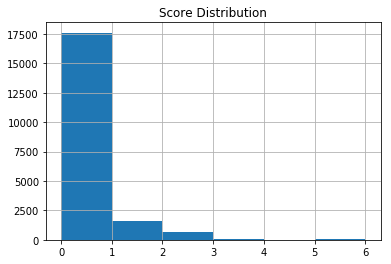

In [25]:
import matplotlib.pyplot as plt
plt.hist(iclink.score, bins=6)
plt.title('Score Distribution')
plt.grid()
plt.show()

The underlying variable used for assigning SCORE, NAME_SIMILARITY, follows a distribution from 0 (Least Similar) - 100 (Most Similar). And the distribution of this variable is shown below.

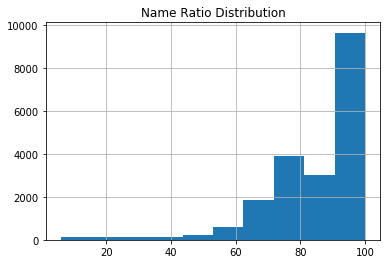

In [44]:
plt.hist(iclink.name_ratio.dropna())
plt.title('Name Ratio Distribution')
plt.grid()
plt.show()

And finally, below is a subset of the final ICLINK dataframe to provide a more intuitive understanding of the output.

In [58]:
iclink[iclink.ticker.isin(['BAC', 'DELL', 'FFS', 'IBM', 'MSFT'])]

,cname,comnam,name_ratio,permno,score,ticker
2166,BANKAMERICA CA,BANKAMERICA CORP,88.0,58827.0,0,BAC
5207,DELL INC,DELL INC,100.0,11081.0,0,DELL
6793,1ST FED BCP DEL,FIRST FEDERAL BANCORP DE,51.0,75161.0,3,FFS
9017,IBM,INTERNATIONAL BUSINESS MACHS CO,12.0,12490.0,1,IBM
11894,MICROSOFT,MICROSOFT CORP,100.0,10107.0,0,MSFT
